# Rozhodovací stromy: učení se z dat
  
  * V tomto notebooku byste se měli naučit, jak vytvořit (naučit) model dat ve formě rozhodovacího stromu.
  * Ukážeme si typický způsob, jak se toto dělá a představíme si i základní API knihovny `sklearn`.
  * Začneme s daty a skončíme s naučeným modelem, o kterém budeme tušit, jak je dobrý.

In [1]:
import math
import pandas as pd
import numpy as np

## Data: základní přehled

  * Použijeme balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.
  * Data jsme stáhli ze serveru **kaggle.com**, kde můžete také najít [popis jednotlivých příznaků](https://www.kaggle.com/uciml/adult-census-income).

In [2]:
data = pd.read_csv('adult-census.csv')
display(data.shape)
display(data.head())
display(data.info())
display(data.describe())
display(data.nunique())

(32561, 15)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

### Chybějící hodnoty

  * Některé příznaky jsou očividně nevyplněné, ale `pandas` hlásí, že žádné nechybí. Je to tím, že chybějící hodnoty nejsou zakódované jako `NaN` ale jsou nahrazeny otazníkem `?`.

In [3]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
data.info()
data.isnull().sum(axis=0)
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    31978 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


## První pokus o použití rozhodovacího stromu implementovaného v `sklearn`

    

 * [Zde](http://scikit-learn.org/stable/modules/tree.html) najdete dokumentaci k rozhodovacím stromům v balíčku `tree` knihovny `scikit-learn`.
 * Naším cílem je pouze zjistit, jestli už máýme data připravená k tomu, aby si s nimi tato implementace poradila.

In [4]:
from sklearn.tree import DecisionTreeClassifier
# uložíme si vysvětlovanou proměnnou (poslední sloupec income) a příznaky
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1] 

  * V knihovně `scikit-learn` mají modely jednotný interface (API).
  * Nejdříve se vždy nastaví hyperparametry modelu (jaké jsou k dispozici lze zjistit pomocí nápovědy) a "nastavený" model se uloží do proměnné:

In [5]:
dt = DecisionTreeClassifier()
dt.get_params

<bound method BaseEstimator.get_params of DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')>

  * Model se pak "naučí" na datech pomocí metody `.fit()`. 
  * V případě supervizovaných modelů vyžaduje většinou matici (`pandas.DataFrame`) s příznaky a vektor (`pandas.Series`) s vysvětlovanou proměnnou.

In [6]:
# dt.fit(Xdata, ydata)

  * **Ajajaj, nefunguje to:**: implementace rozhodovacího stromu v `sklearn` si neumí poradit ne nečíselnými (nenumerickými) příznaku.
  * Musíme proto nahradit stringy nějakými jejich kódy.
  * **ÚKOL:** Zjistěte, jaký je vztah mezi příznaky *education* a *education.num*. 

In [7]:
### sem přijde Váš kód


In [8]:
display(data.dtypes)
display(data.nunique())
string_cols = data.select_dtypes(['object']).columns
print(string_cols)
data[string_cols].nunique()

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

age                  73
workclass             8
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           14
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       41
income                2
dtype: int64

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')


workclass          8
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64

  * Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Můžeme je tedy všechny nahradit číselnými kódy.
  * Je v `pandas` nějaká metoda, která to umí? Samozřejmě ano. Je ale nutné typ příznaku v `pandas` změnit na `category`.

In [9]:
for col in string_cols:
    data[col] = data[col].astype('category')
data[string_cols] = data[string_cols].apply(lambda x: x.cat.codes)
data.info()
# did it work?
data["native.country"].unique()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null int8
fnlwgt            32561 non-null int64
education         32561 non-null int8
education.num     32561 non-null int64
marital.status    32561 non-null int8
occupation        32561 non-null int8
relationship      32561 non-null int8
race              32561 non-null int8
sex               32561 non-null int8
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null int8
income            32561 non-null int8
dtypes: int64(6), int8(9)
memory usage: 1.8 MB


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,-1,77053,11,9,6,-1,1,4,0,0,4356,40,38,0
1,82,3,132870,11,9,6,3,1,4,0,0,4356,18,38,0
2,66,-1,186061,15,10,6,-1,4,2,0,0,4356,40,38,0
3,54,3,140359,5,4,0,6,4,4,0,0,3900,40,38,0
4,41,3,264663,15,10,5,9,3,4,0,0,3900,40,38,0


  * A teď to můžeme zkusit s `DecisionTreeClassifier` znovu!
  * Co se stalo s `NaN` položkami?

In [10]:
data.occupation.unique()
data.groupby(["occupation"]).size() # ve sloupco occupation bylo 1843 chybějících hodnot

occupation
-1     1843
 0     3770
 1        9
 2     4099
 3     4066
 4      994
 5     1370
 6     2002
 7     3295
 8      149
 9     4140
 10     649
 11    3650
 12     928
 13    1597
dtype: int64

**Chybějící hodnoty byly nahrazeny nulami!**

Jak se vypořádat s chybějícími hodnotami je docela věda. Jejich nahrazení jedinou unikátní hodnotou je takový nejjednodušší (a skutečně používaný) způsob.)

In [11]:
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1]
dt = DecisionTreeClassifier()
dt.fit(Xdata, ydata)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Učení stromu

  * Cílem je vytvořit rozhodovací strom, který bude předpovídat *income* daných osob.
  * Chceme také najít nejlepší hodnoty parametrů `max_depth` a `criterion` metody `DecisionTreeClassifier`. takovýmto parametrům metody se říká *hyperparametery*.
  * Jak víme z přednášky, správný způsob ladění hyperparametrů vyžaduje rozdělení dat na trénovací, valdační a testovací.
  * A samozřejmě v `sklearn` je na to balíček.

In [12]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xtest.shape)
display(ytest.shape)

(24420, 14)

(24420,)

(8141, 14)

(8141,)

In [13]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xval.shape)
display(yval.shape)

(18315, 14)

(18315,)

(6105, 14)

(6105,)

### Měření trénovací chyby pomocí klasifikační přesnosti

In [14]:
dt = DecisionTreeClassifier(max_depth=50)
dt.fit(Xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

  * Rozhodovací strom máme hotový, nyní můžeme použít metodu `predict()`, abychom získali predikce, které dává strom pro trénovací data.

In [15]:
ypredicted = dt.predict(Xtrain)
ypredicted

array([0, 0, 0, ..., 0, 0, 1], dtype=int8)

In [16]:
(ytrain - ypredicted).value_counts(normalize=True)

0    0.999945
1    0.000055
Name: income, dtype: float64

  * Přesnost na trénovacích datech je  (pro `max_depth` = 50) skoro 100 %! 
  * Měřit přesnost a různé metriky nemusíme takto ručně, v `sklearn` je na to samozřejmě balíček:

In [17]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))

accuracy score (train): 0.999945


S testovacími daty to tak skvěle nedopadne:

In [18]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.815379


### Ladění hyperparameterů `max_depth` a `criterion`

  * Začněme s hyperparametrem `max_depth`.
  * Jak víme, budeme používat validační množinu.
  * Prozkoumáme hodnoty od 1 do 100.

In [19]:
val_acc = []
train_acc = []
for depth in range(1,101):
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

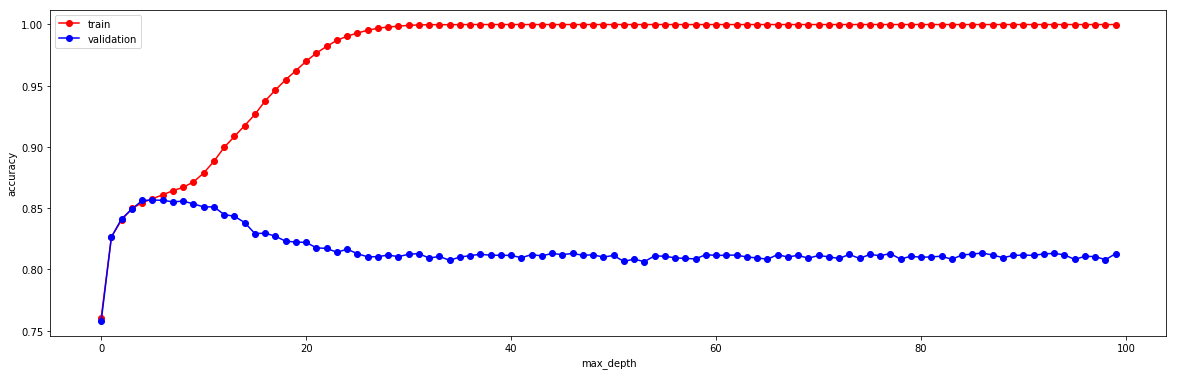

In [20]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [21]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

6

Spočítejme **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [22]:
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(Xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.849650


### Grid search: ladění více hyperparameterů

  * Chceme projít hodnoty `max_depth` z intervalu [1, 100] a obě možné hodnoty `criterion`, tj. 200 různých kombinací.
  * Můžeme samozřejmě použít dva vnořené for cykly (což je hrozné) nebo použít `ParameterGrid` balíček.

In [23]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# just to see the result:
[param_comb[i] for i in range(2)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'}]

In [24]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

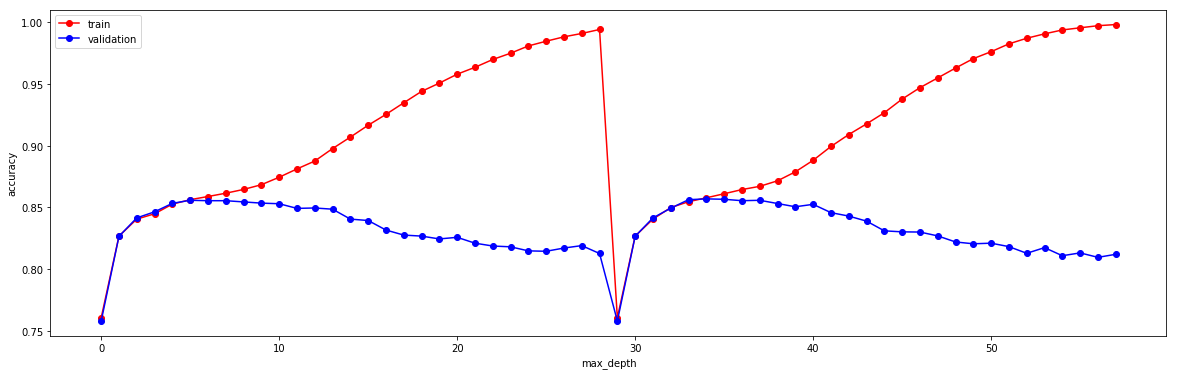

In [25]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [26]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 6, 'criterion': 'gini'}

In [27]:
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'])
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.857712
accuracy score (validation): 0.856839
accuracy score (test): 0.850018


### ÚKOL: naučte strom na datech k Titaniku z minulého cvičení

  * Hyperparametry k tunění si vyberte sami.
  * Rozdělte data ve stejných poměrech a se stejným `random_state` v metode `train_test_split()` jeko výše.

In [28]:
data2 = pd.read_csv('titanic.csv')
### sem přijde Váš kód

# Jak vykreslit strom

  * Je třeba mít nainstalovaný [graphviz](https://www.graphviz.org/) nebo použít http://webgraphviz.com/.

In [2]:
# we can plot the tree using Graphviz
# the Grapwhiz must be installed on your system, if you do not want to bother, use http://webgraphviz.com/
from sklearn import tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

def plotTree(dt):
    dot_data = StringIO()
    tree.export_graphviz(dt, out_file=dot_data,  
                    filled=True, rounded=True,
                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

In [3]:
data = pd.read_csv('simple_data.csv', sep=';')
display(data.head(16)) 
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(data.iloc[:,1:],data['T'])

NameError: name 'pd' is not defined

In [ ]:
plotTree(dt)